In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TransformerModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = TransformerModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=28,
        output_chunk_length=2,
        d_model=128,
        nhead=4,
        num_encoder_layers=1,
        num_decoder_layers=1,
        activation="Bilinear",
        n_epochs=100,
        batch_size=153,
        dropout=0.11806248396557542,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        optimizer_kwargs={"lr": 0.0007930360578326748, "weight_decay": 0.00013997625135104947}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=2,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.035
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.027
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.024
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.001

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     8.946481    2.991067    2.370500  0.821317   
Precipitation_accumulated       0.381664    0.617789    0.421368  0.394515   
Humidity                       96.472007    9.822016    8.078095  0.692792   
Wind_Speed_kmh                  0.540041    0.734875    0.572893 -0.277745   
Soil_Moisture              207882.633926  455.941481  389.136378  0.664979   
Soil_Temperature               14.018914    3.744184    2.885557  0.807341   
Wind_Dir_Sin                    0.341148    0.584079    0.473749 -0.067498   
Wind_Dir_Cos                    0.543221    0.737035    0.572116 -0.404299   

                                SMAPE  
Temperature                 14.731010  
Precipitation_accumulated   12.751173  
Humidity                    12.438528  
Wind_Speed_kmh              58.177627  
Soil_Mo

Metric val_loss improved. New best score: 6.255
Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 6.243
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 6.236
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 6.228
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 6.223
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 6.221
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 6.216
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 6.211
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 6.207
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.204
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 6.203
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.199
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 6.198
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE         R2  \
Temperature                    48.347645    6.953247    5.595937  -0.393709   
Precipitation_accumulated  144772.719526  380.490104  325.073584  -2.655589   
Humidity                     5373.787046   73.306119   63.312101 -41.834933   
Wind_Speed_kmh                  2.737042    1.654401    1.477475  -7.352938   
Soil_Moisture              895647.629476  946.386617  814.862775   0.401027   
Soil_Temperature              132.417555   11.507283    9.495127  -2.696039   
Wind_Dir_Sin                    1.240611    1.113827    0.997255  -4.241888   
Wind_Dir_Cos                    0.368421    0.606977    0.537889   0.435355   

                                SMAPE  
Temperature                 37.153893  
Precipitation_accumulated  143.942054  
Humidity                   147.273328  
Wind_Speed_kmh             137.891534 

Metric val_loss improved. New best score: 0.036
Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.009
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.007
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.006
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.003. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inferenc

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    6.015209    2.452592    2.027982 -8.140020e-02   
Precipitation_accumulated   2153.679125   46.407749   44.095569 -1.829463e+07   
Humidity                      35.505507    5.958650    5.097887 -1.061649e+00   
Wind_Speed_kmh                 0.038004    0.194945    0.155996          -inf   
Soil_Moisture              68092.755985  260.945887  229.203599 -4.988574e+01   
Soil_Temperature               4.108821    2.027023    1.658959  3.492380e-01   
Wind_Dir_Sin                   0.020055    0.141614    0.124591          -inf   
Wind_Dir_Cos                   0.016572    0.128733    0.097090          -inf   

                                SMAPE  
Temperature                 13.359066  
Precipitation_accumulated    9.139701  
Humidity                     5.674121  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.007
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    4.558714    2.135115    1.973341 -7.086257e+00   
Precipitation_accumulated    413.679418   20.339111   19.679988 -1.251814e+04   
Humidity                      13.031187    3.609874    2.925144 -3.354908e-01   
Wind_Speed_kmh                 0.028940    0.170116    0.155614          -inf   
Soil_Moisture              57476.255333  239.742060  196.024969 -6.640335e-01   
Soil_Temperature               3.984280    1.996066    1.821507 -1.661209e+01   
Wind_Dir_Sin                   0.000524    0.022900    0.019381          -inf   
Wind_Dir_Cos                   0.007279    0.085316    0.071403          -inf   

                                SMAPE  
Temperature                 18.809271  
Precipitation_accumulated    4.197692  
Humidity                     3.232095  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.007
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.003. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many worker

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE          R2  \
Temperature                    1.663820    1.289891   1.024551    0.299440   
Precipitation_accumulated    100.101707   10.005084   8.764105 -351.005003   
Humidity                      90.528653    9.514655   7.987846   -0.941296   
Wind_Speed_kmh                 0.197764    0.444707   0.415372  -94.100048   
Soil_Moisture              12080.421804  109.910972  70.905363   -0.501392   
Soil_Temperature               1.107890    1.052564   0.865983    0.316324   
Wind_Dir_Sin                   0.038188    0.195417   0.101221    0.339773   
Wind_Dir_Cos                   0.054875    0.234253   0.105705    0.379322   

                                SMAPE  
Temperature                 15.262195  
Precipitation_accumulated    1.886151  
Humidity                     9.310237  
Wind_Speed_kmh             194.919901  
Soil_Mo

Metric val_loss improved. New best score: 0.025
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.021
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.021. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE  \
Temperature                6.178767e+00     2.485712     1.927312   
Precipitation_accumulated  2.333142e+03    48.302604    43.123698   
Humidity                   6.846666e+01     8.274458     7.591881   
Wind_Speed_kmh             1.742620e+00     1.320083     0.875741   
Soil_Moisture              1.486169e+06  1219.085191  1084.362233   
Soil_Temperature           6.093264e+00     2.468454     2.023827   
Wind_Dir_Sin               4.855775e-01     0.696834     0.540983   
Wind_Dir_Cos               3.527364e-01     0.593916     0.482163   

                                    R2       SMAPE  
Temperature                   0.341819   49.733079  
Precipitation_accumulated -2014.309557    9.907106  
Humidity                      0.406329    8.586253  
Wind_Speed_kmh               -0.120103  112.615890  
Soil_Moisture          

Metric val_loss improved. New best score: 0.023
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.013. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    4.087445    2.021743    1.638930     0.848933   
Precipitation_accumulated    665.483740   25.796972   19.854931 -2276.063064   
Humidity                      38.141060    6.175845    4.923777     0.747545   
Wind_Speed_kmh                 0.985002    0.992473    0.814635     0.180323   
Soil_Moisture              30565.194601  174.829044  147.148472    -4.168242   
Soil_Temperature               2.880652    1.697248    1.415691     0.741654   
Wind_Dir_Sin                   0.472449    0.687349    0.568220     0.118783   
Wind_Dir_Cos                   0.325987    0.570953    0.471843     0.040891   

                                SMAPE  
Temperature                 17.685731  
Precipitation_accumulated    4.420946  
Humidity                     6.054903  
Wind_Speed_kmh              6

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


TransformerModel(output_chunk_shift=0, d_model=128, nhead=4, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=512, dropout=0.11806248396557542, activation=Bilinear, norm_type=None, custom_encoder=None, custom_decoder=None, model_name=model_1, input_chunk_length=28, output_chunk_length=2, n_epochs=100, batch_size=153, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f54b3989040>]}, loss_fn=HuberLoss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwarg

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


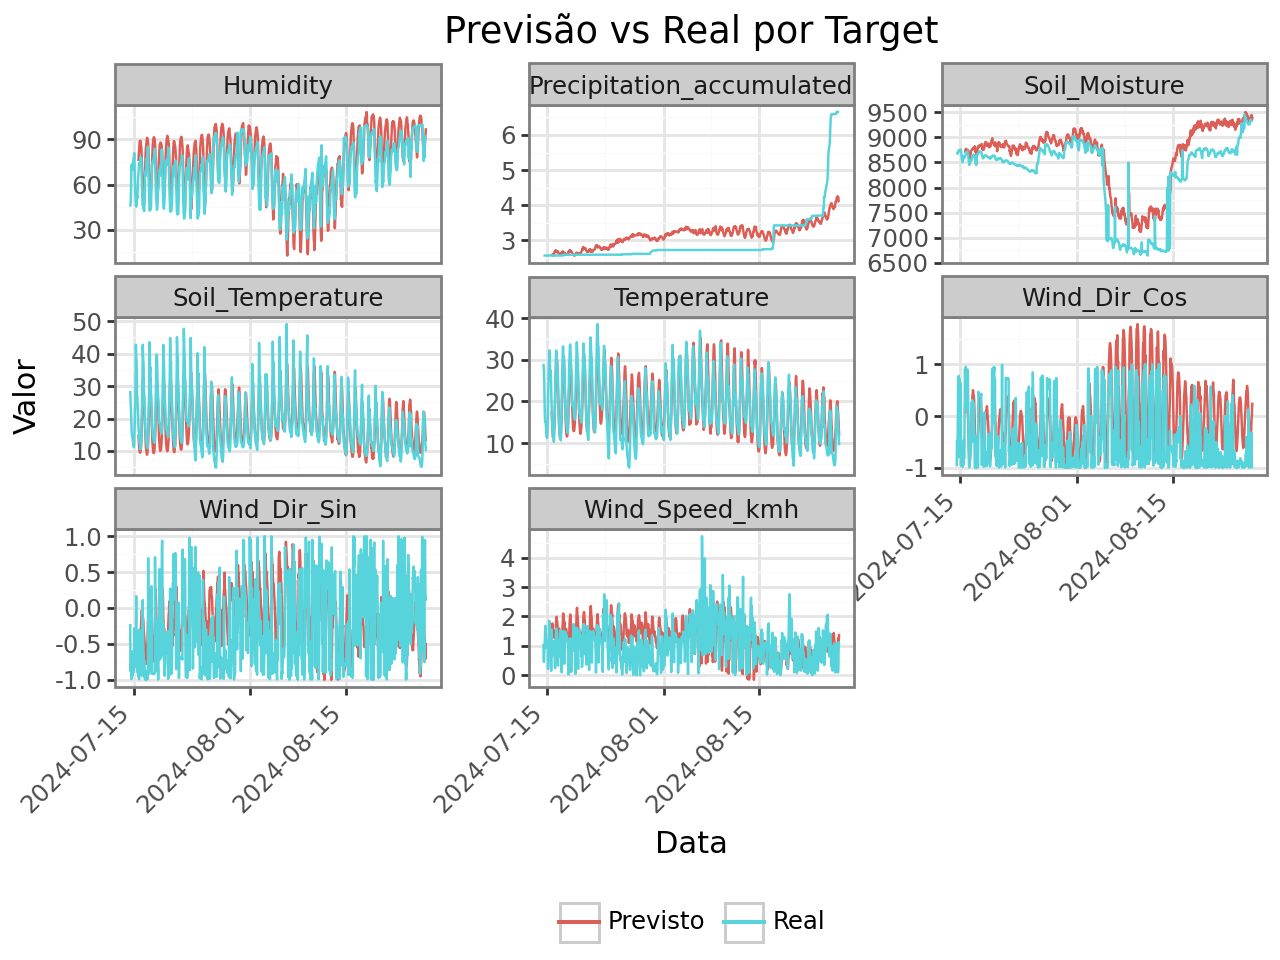

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [8]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

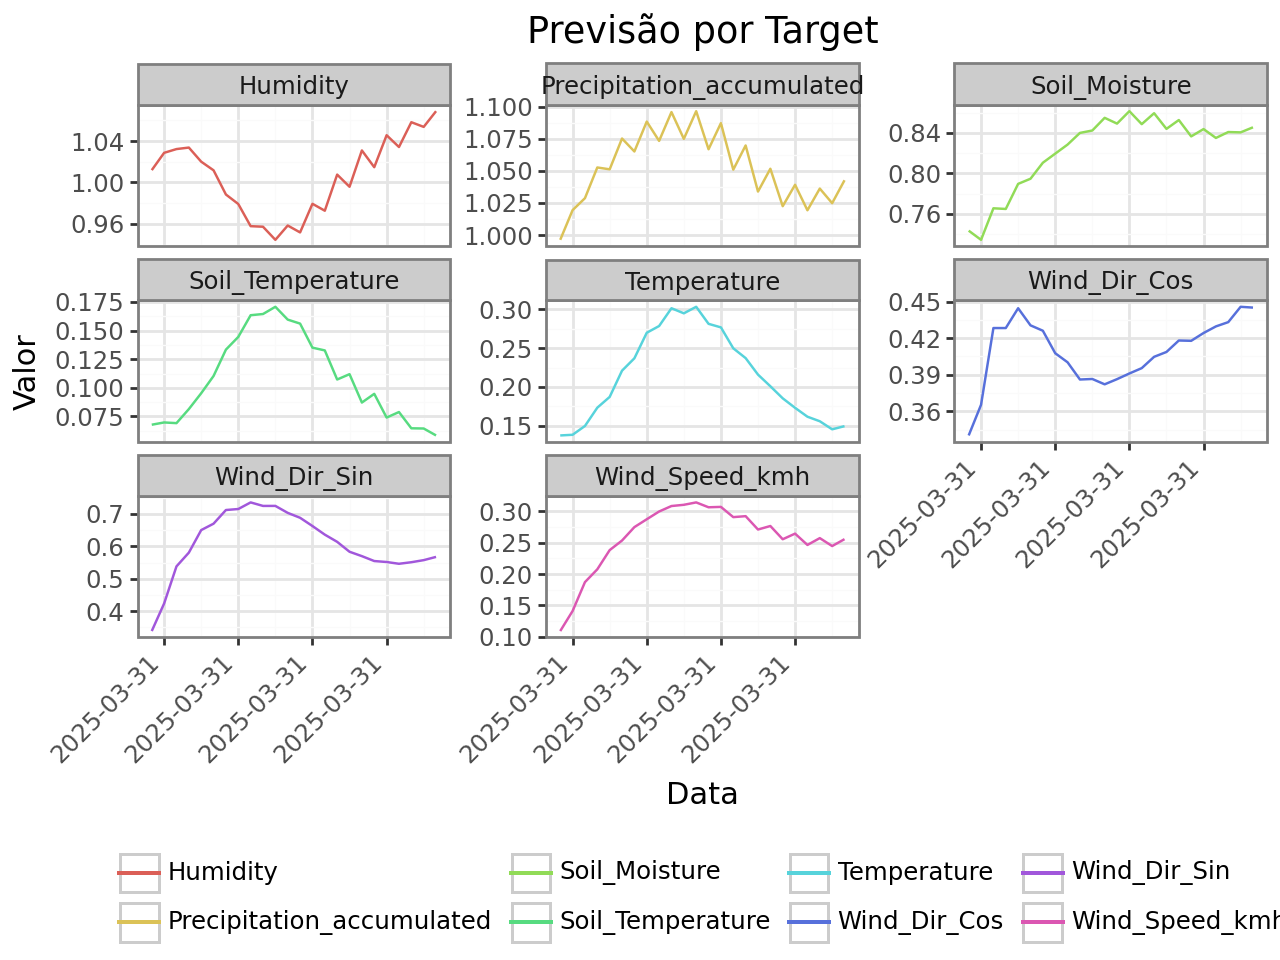

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [9]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [10]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)